In [1]:
import sys
import os
import logging

import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines # importance ranking
import seaborn as sns
import shap

from BDT import (
    read_data,
    read_features,
    prepare_test_data,
    prepare_test_data_matrix,
    prepare_data_matrix,
)
shap.initjs()

In [2]:
# load data and model
SPLIT_FRACTION = 0.5
data = read_data("./input/")
feature_names = read_features(data)
data_test = prepare_test_data(data, SPLIT_FRACTION)
test_data_matrix = prepare_test_data_matrix(data_test, feature_names)

X = data[feature_names]

booster = xgb.Booster()
booster.load_model("./output/booster.bin")
booster.feature_names = feature_names # save_model does not save feature names
booster.feature_types = ['float' for x in range(15)]

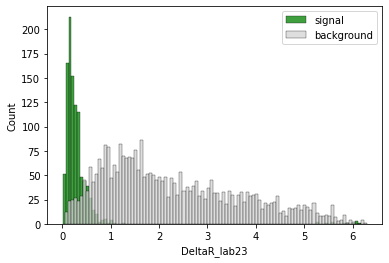

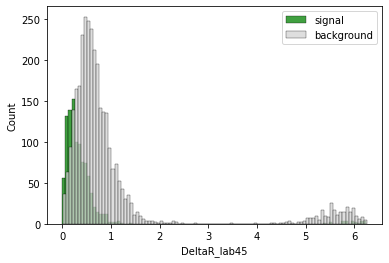

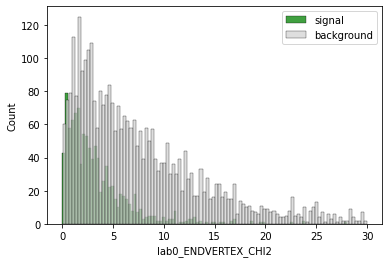

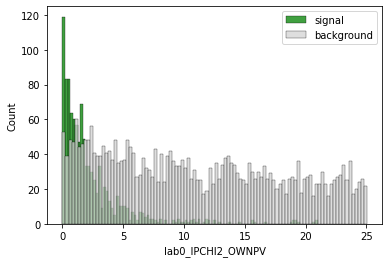

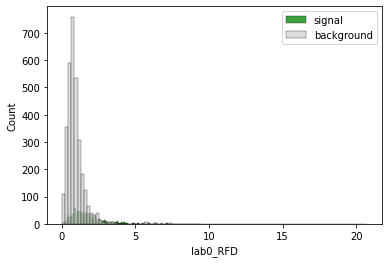

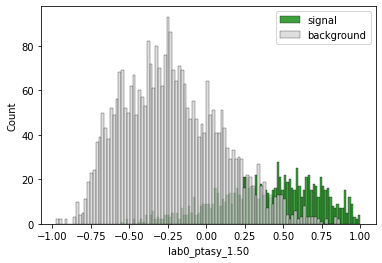

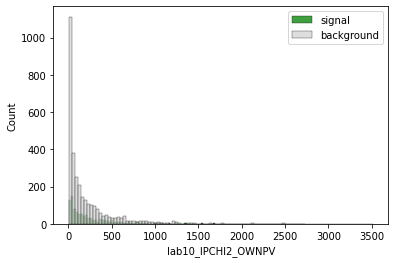

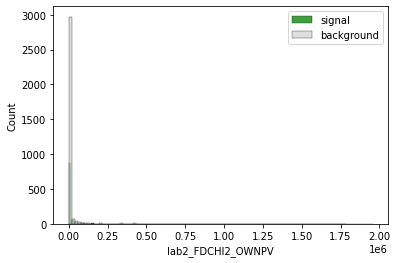

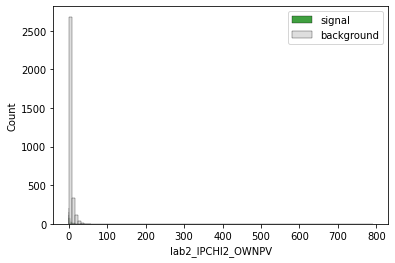

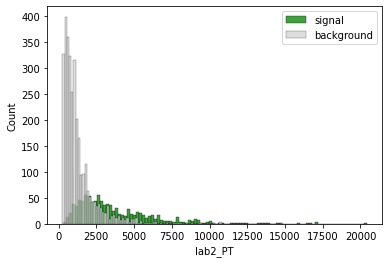

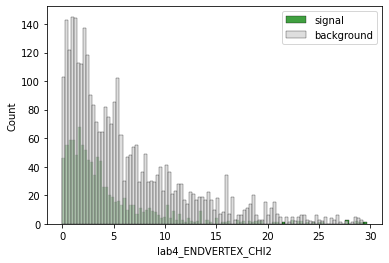

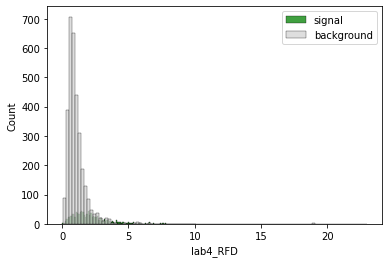

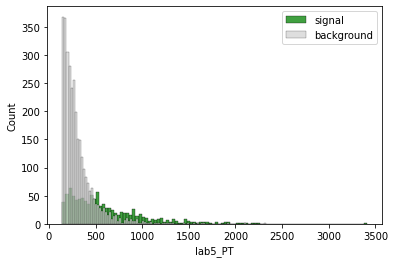

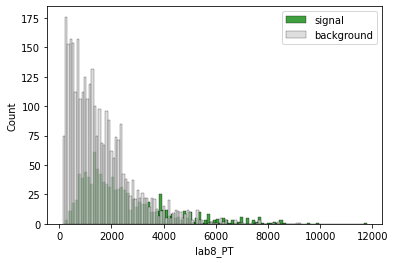

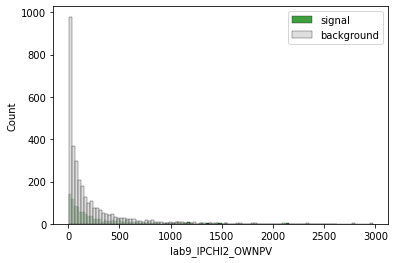

In [3]:
# Plot classification by feature
float_predictions = booster.predict(test_data_matrix).tolist()
predictions = list(map(round, float_predictions))
for feature_name in data_test[feature_names]:
    feature = pd.DataFrame(data_test[feature_name])
    feature.insert(1, "prediction", predictions, True)
    signal = feature[feature["prediction"] == 1]
    background = feature[feature["prediction"] == 0]
    
    plt.figure()
    sns.histplot(signal[feature_name], bins=100, color="green", label="signal")
    sns.histplot(background[feature_name], bins=100, color="lightgray", label="background")
    plt.legend()


In [14]:
# calculate shap values
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X)

[[-3.4647052  -0.45295903  0.3790967  ...  0.08923692 -0.44538003
  -0.11122084]
 [-3.4890065   0.2605429   0.03500993 ... -0.30404204  0.03740602
  -0.31631255]
 [-3.3146293  -0.31967095  0.07135984 ...  0.06800231 -0.01857585
  -0.10985302]
 ...
 [ 4.0616565   1.0636023   0.48707077 ...  0.6153948   0.25924367
   0.05656815]
 [-1.8091778  -1.612163    0.14909104 ... -0.39375955 -0.14230515
  -0.19073954]
 [-4.155842   -0.25977102  0.35681388 ... -0.32790625  0.22850087
   0.47566542]]


In [5]:
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

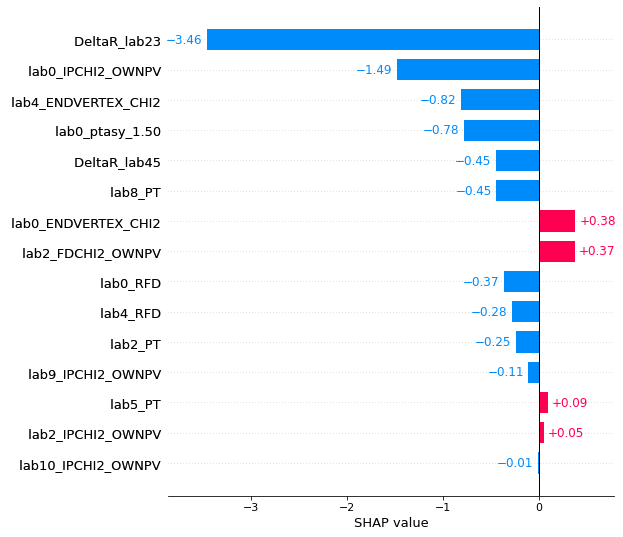

In [6]:
shap.plots.bar(explainer(X)[0], max_display=20)

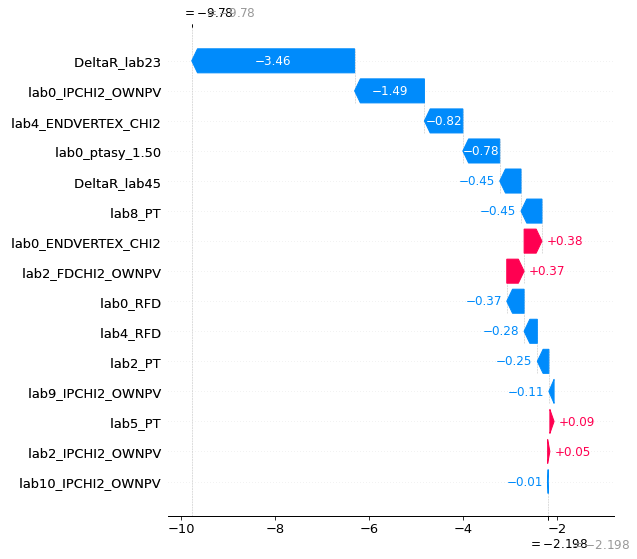

In [7]:
shap.waterfall_plot(explainer(X)[0], max_display=20)

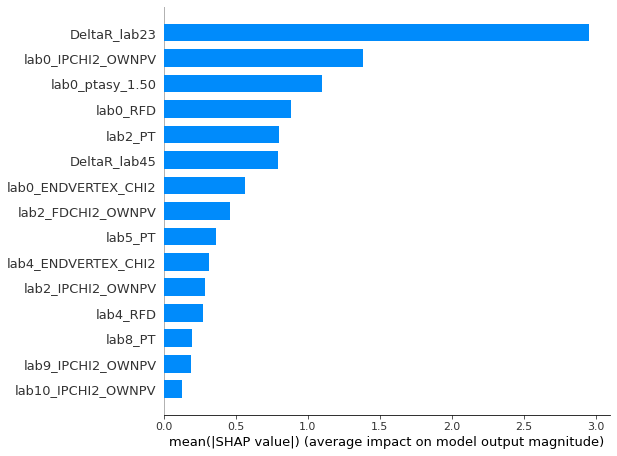

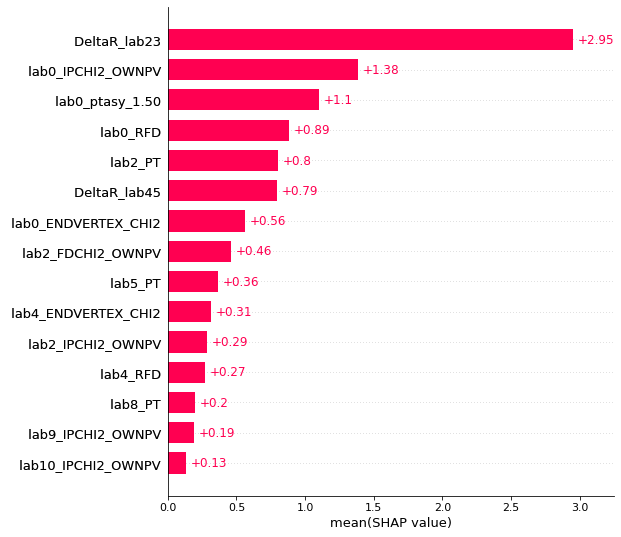

' Lepsze od xgb.plot_importance bo ta funkcja zlicza tylko ile razy została użyta zmienna do decyzji'

In [8]:
# summarize the effects of all the features (bar plot)
shap.summary_plot(shap_values, X, plot_type="bar")
# global feature importance plot
shap.plots.bar(explainer(X), max_display=20)
""" Lepsze od xgb.plot_importance bo ta funkcja zlicza tylko ile razy została użyta zmienna do decyzji"""

In [9]:
# shap_importance = dict(zip(feature_names, abs(shap_values).mean(axis=0)))
# xgb_importance = booster.get_score(importance_type="total_cover")

# shap_rank = {feature_name: rank for rank, feature_name in enumerate(sorted(shap_importance, key=shap_importance.get, reverse=True), 1)}
# xgb_rank = {feature_name: rank for rank, feature_name in enumerate(sorted(xgb_importance, key=xgb_importance.get, reverse=True), 1)}
# feature_rank = [[feature, xgb_rank[feature], shap_rank[feature]] for feature in feature_names]

# df = pd.DataFrame(feature_rank, columns=["feature", "xgb", "shap"])

# # draw line
# def newline(p1, p2, color='black'):
#     ax = plt.gca()
#     l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color='red' if p2[1]-p1[1] > 0 else 'green', marker='o', markersize=6)
#     ax.add_line(l)
#     return l

# fig, ax = plt.subplots(1,1,figsize=(14,14), dpi= 80)

# # Vertical Lines
# ax.vlines(x=1, ymin=0, ymax=16, color='black', alpha=0.7, linewidth=1, linestyles='dotted')
# ax.vlines(x=3, ymin=0, ymax=16, color='black', alpha=0.7, linewidth=1, linestyles='dotted')

# # Points
# ax.scatter(y=df['xgb'], x=np.repeat(1, df.shape[0]), s=10, color='black', alpha=0.7)
# ax.scatter(y=df['shap'], x=np.repeat(3, df.shape[0]), s=10, color='black', alpha=0.7)

# # Line Segmentsand Annotation
# for p1, p2, c in zip(df['xgb'], df['shap'], df['feature']):
#     newline([1,p1], [3,p2])
#     ax.text(1-0.05, p1, c + ', ' + str(round(p1)), horizontalalignment='right', verticalalignment='center', fontdict={'size':14})
#     ax.text(3+0.05, p2, c + ', ' + str(round(p2)), horizontalalignment='left', verticalalignment='center', fontdict={'size':14})

# # 'Before' and 'After' Annotations
# ax.text(1-0.05, 0, 'XGB', horizontalalignment='right', verticalalignment='center', fontdict={'size':18, 'weight':700})
# ax.text(3+0.05, 0, 'SHAP', horizontalalignment='left', verticalalignment='center', fontdict={'size':18, 'weight':700})

# # Decoration
# ax.set_title("Feature Importance Ranking", fontdict={'size':22})
# ax.set(xlim=(0,4), ylim=(0,16), ylabel='Feature Importance')
# # ax.set_xticks([1,3])
# # ax.set_xticklabels(["XGB", "SHAP"])
# # plt.yticks(np.arange(0, 16, 1), fontsize=12)

# # Lighten borders
# plt.gca().spines["top"].set_alpha(.0)
# plt.gca().spines["bottom"].set_alpha(.0)
# plt.gca().spines["right"].set_alpha(.0)
# plt.gca().spines["left"].set_alpha(.0)
# plt.gca().invert_yaxis()

# plt.axis("off")
# plt.show()

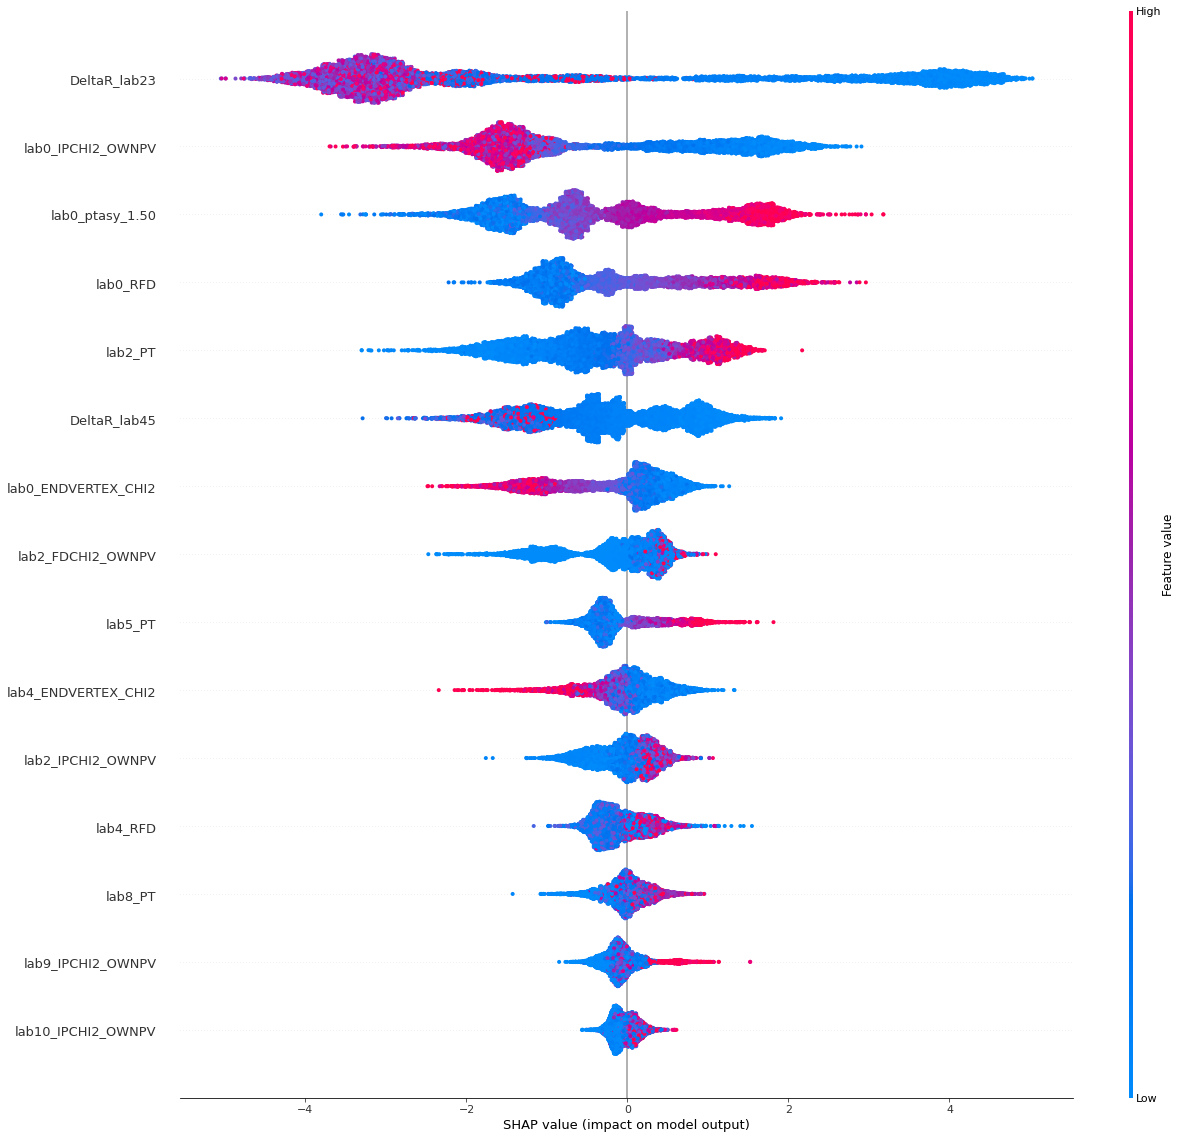

"\nWykres sumaryczny uwzględnia wszystkie cechy użyte w modelu. Prezentowane ponizej cechy są posortowane według\nwartości bezwzględnej ich wpływu na predykcje modelu. Cecha o największym wpływie na model to 'DeltaR_lab23', a ta\no najmniejszym wpływie na model to 'lab10_IPCHI2_OWNPV'. Ponadto patrząc na przykład na cechę 'DeltaR_lab23'\nmożna zauważyć, że niskie wartości tej cechy (niebieski kolor) mocno wpływają na zaklasyfikowanie próby jako sygnał.\n"

In [10]:
# summarize the effects of all the features (beehive plot)
shap.summary_plot(shap_values, X, plot_size=(20, 20))
"""
Wykres sumaryczny uwzględnia wszystkie cechy użyte w modelu. Prezentowane ponizej cechy są posortowane według
wartości bezwzględnej ich wpływu na predykcje modelu. Cecha o największym wpływie na model to 'DeltaR_lab23', a ta
o najmniejszym wpływie na model to 'lab10_IPCHI2_OWNPV'. Ponadto patrząc na przykład na cechę 'DeltaR_lab23'
można zauważyć, że niskie wartości tej cechy (niebieski kolor) mocno wpływają na zaklasyfikowanie próby jako sygnał.
"""

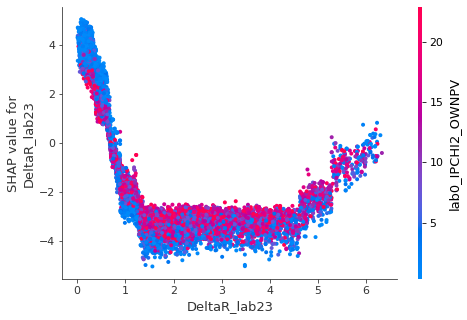

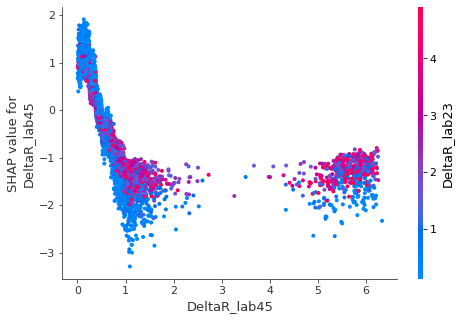

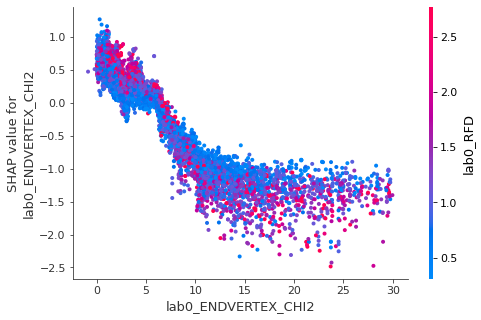

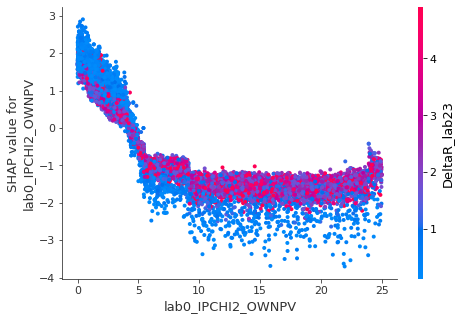

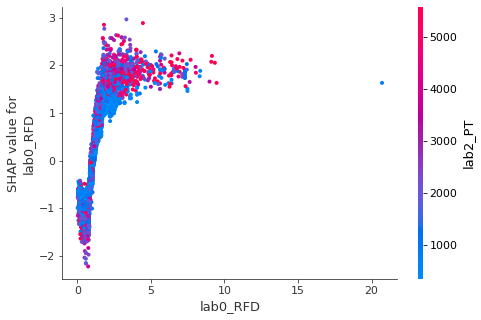

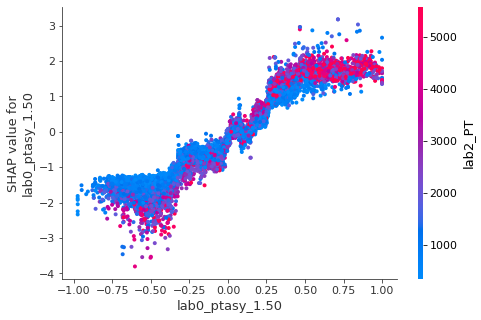

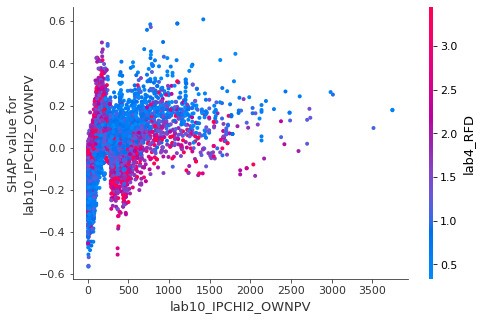

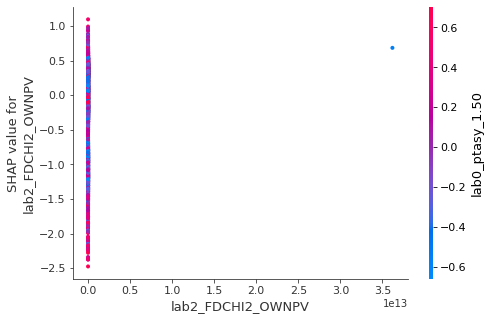

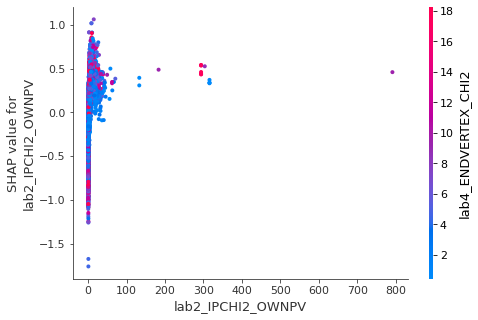

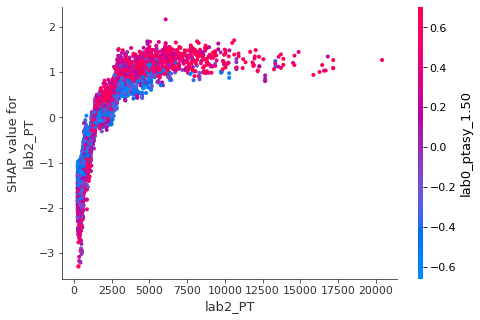

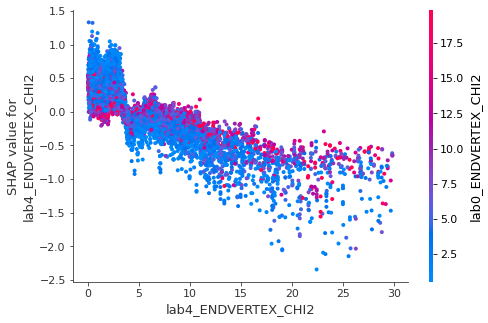

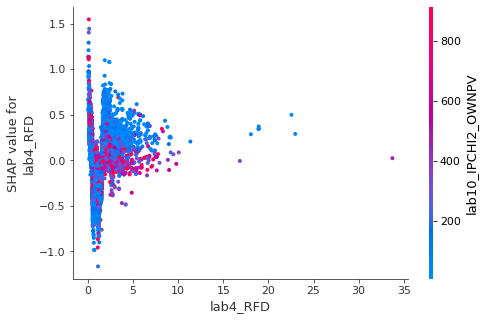

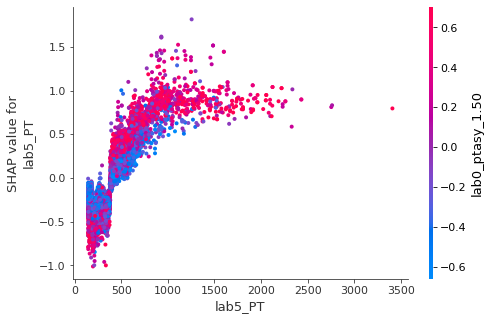

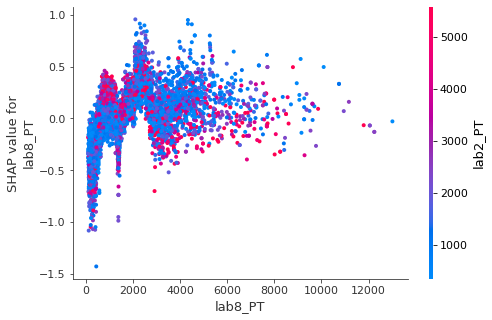

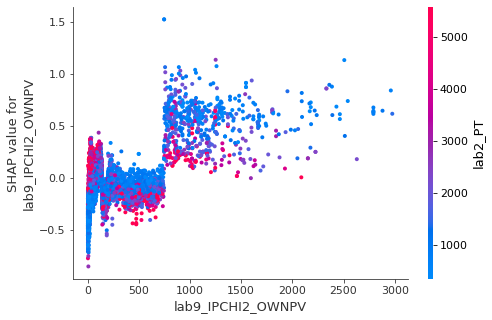

In [11]:
# dependence plots - 15*14=210 plots
# decide if there is any value in this
# the second feature (color) is chosen automatically by shap.common.approximate_interactions
for feature_name in feature_names:
    shap.dependence_plot(feature_name, shap_values, X)

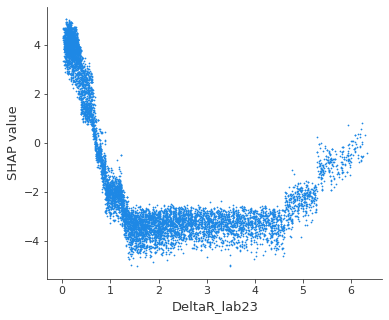

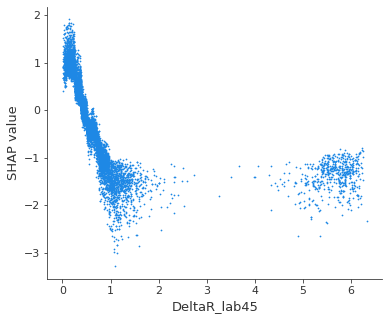

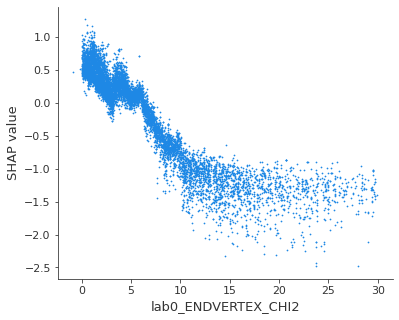

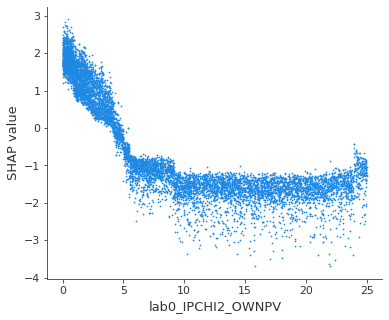

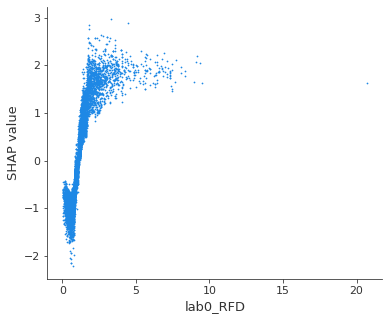

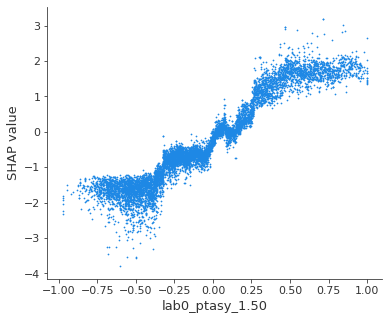

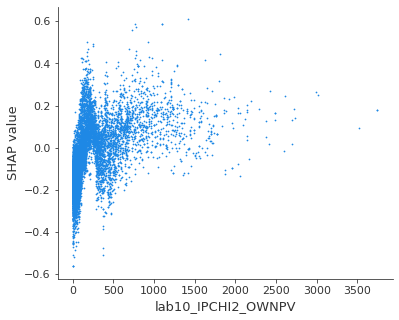

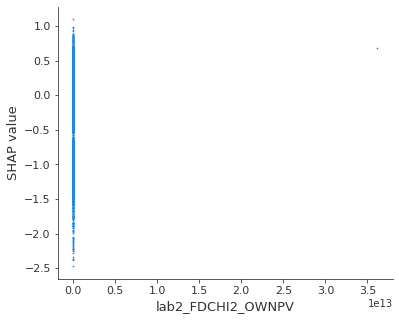

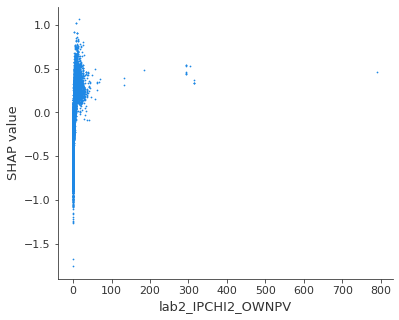

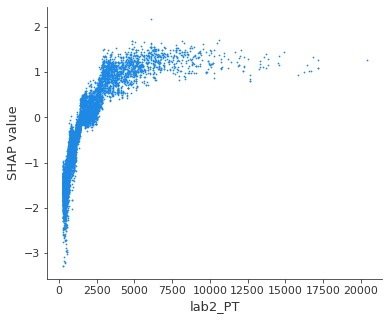

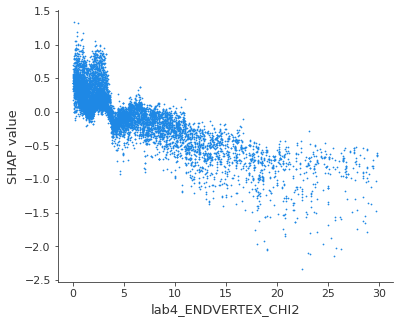

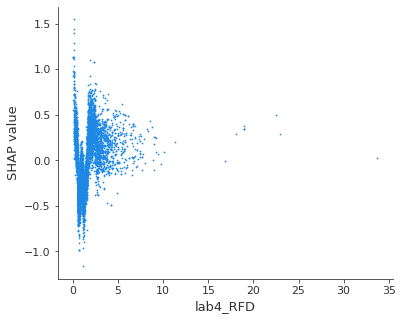

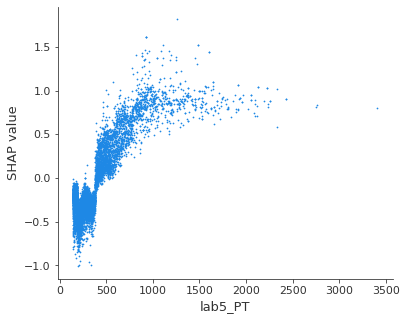

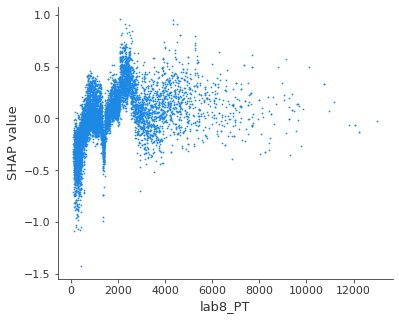

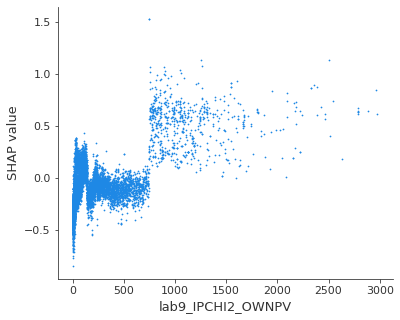

In [26]:
# Bez interakcji, tylko wpływ cechy na predykcje modelu
# Czy jest w tym jakaś wartościowa informacja?
for feature_name in feature_names:
    shap.dependence_plot(feature_name, shap_values, X, dot_size=3, interaction_index=None, show=False)
    plt.ylabel("SHAP value")
    
    
    plt.show()

In [67]:
handles = [
    mlines.Line2D([0], [0], marker='o', color='w', label='Scatter', markerfacecolor='g', markersize=10),
    mlines.Line2D([0], [0], marker='o', color='w', label='Scatter', markerfacecolor='lightgray', markersize=10),
]
colors = [ "green" if label == 's' else "lightgray" for label in data.Label ]

for idx, feature in enumerate(feature_names):
    print(feature)
    fig1 = plt.figure()
    sv = shap_values[:,idx]
    fv = X[feature]    
    plt.scatter(fv, sv, s=2, c=colors)
    plt.xlabel(feature)
    plt.ylabel("SHAP value")
    plt.legend(handles, ["signal", "background"])
#   if feature in ["lab2_FDCHI2_OWNPV", "lab2_IPCHI2_OWNPV"]:
#        plt.xscale("log")
#     plt.show()
    file_name1 = f"img/shap/shap_{feature}.png"
    plt.savefig(file_name1)
    plt.close(fig1)
    
    fig2 = plt.figure()
    plt.scatter(fv, sv, s=2, c=colors)
    plt.xlabel(feature)
    plt.ylabel("SHAP value")
    plt.legend(handles, ["signal", "background"])
    plt.xscale("log")
#     plt.show()
    file_name2 = f"img/shap/shap_{feature}_log.png"
    plt.savefig(file_name2)
    plt.close(fig2)

    


DeltaR_lab23
DeltaR_lab45
lab0_ENDVERTEX_CHI2
lab0_IPCHI2_OWNPV
lab0_RFD
lab0_ptasy_1.50
lab10_IPCHI2_OWNPV
lab2_FDCHI2_OWNPV
lab2_IPCHI2_OWNPV
lab2_PT
lab4_ENDVERTEX_CHI2
lab4_RFD
lab5_PT
lab8_PT
lab9_IPCHI2_OWNPV


In [69]:
latex_1 = r"""\begin{figure}[ht]
    \centering
    \begin{subfigure}{0.49\textwidth}
            \includegraphics[width=\textwidth]"""
latex_2 = r"""
    \end{subfigure}
    \begin{subfigure}{0.49\textwidth}
        \includegraphics[width=\textwidth]"""
latex_3 = r"""
    \end{subfigure}
\end{figure}"""

for feature in feature_names:
    file_string1 = f"{{img/shap/shap_{feature}.png}}"
    file_string2 = f"{{img/shap/shap_{feature}_log.png}}"
    latex_figures = latex_1 + file_string1 + latex_2 + file_string2 + latex_3 + "\n"
    print(latex_figures)

\begin{figure}[ht]
    \centering
    \begin{subfigure}{0.49\textwidth}
            \includegraphics[width=\textwidth]{img/shap/shap_DeltaR_lab23.png}
    \end{subfigure}
    \begin{subfigure}{0.49\textwidth}
        \includegraphics[width=\textwidth]{img/shap/shap_DeltaR_lab23_log.png}
    \end{subfigure}
\end{figure}

\begin{figure}[ht]
    \centering
    \begin{subfigure}{0.49\textwidth}
            \includegraphics[width=\textwidth]{img/shap/shap_DeltaR_lab45.png}
    \end{subfigure}
    \begin{subfigure}{0.49\textwidth}
        \includegraphics[width=\textwidth]{img/shap/shap_DeltaR_lab45_log.png}
    \end{subfigure}
\end{figure}

\begin{figure}[ht]
    \centering
    \begin{subfigure}{0.49\textwidth}
            \includegraphics[width=\textwidth]{img/shap/shap_lab0_ENDVERTEX_CHI2.png}
    \end{subfigure}
    \begin{subfigure}{0.49\textwidth}
        \includegraphics[width=\textwidth]{img/shap/shap_lab0_ENDVERTEX_CHI2_log.png}
    \end{subfigure}
\end{figure}

\begin{figure}[ht]
 

In [13]:
# wizualizacja wpływu wszystkich cech na wiele prób (tutaj 100)
# raczej niepotrzebne
samples = 100
shap.force_plot(explainer.expected_value, shap_values[0:samples], X.iloc[0:samples])